# Install & Import Requirements



In [1]:
!pip install swig
!pip install gymnasium[box2d]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 37.2 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
from torch.distributions.normal import Normal
from torch.optim import Adam
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
from datetime import datetime
from typing import Sequence
from tqdm import tqdm

# Helper functions

## MLP function to create the policy network of our agent

In [3]:
def mlp(sizes: Sequence[int], activation=nn.ReLU, output_activation=nn.Identity) -> nn.Sequential:
  """
  Create a simple feedforward neural network.
  """
  layers = []
  for j in range(len(sizes)-1):
    act = activation if j < len(sizes)-2 else output_activation
    layers += [nn.Linear(sizes[j], sizes[j+1]), act()]
  return nn.Sequential(*layers)

In [4]:
def get_policy(obs: torch.Tensor) -> Normal:
  """
  Get the stochastic policy for a given observation (-batch).
  Returns a distribution for every action.
  """
  obs = obs.unsqueeze(0) if obs.dim() == 1 else obs  # for single observations that do not have a batch dimension
  logits = actor(obs)
  mean, logstd = logits[:, :n_acts], logits[:, n_acts:]  # split the output layer into mean and logstd
  logstd = torch.clamp(logstd, min=-20, max=2)  # for numerical stability
  return Normal(mean, torch.exp(logstd))

In [5]:
def get_action(obs: torch.Tensor) -> np.ndarray:
  """
  Get the action for a given observation.
  """
  dist = get_policy(obs)
  return dist.sample().squeeze(0).numpy()

In [6]:
def compute_gae(rewards: torch.Tensor,
                values: torch.Tensor,
                next_values: torch.Tensor,
                dones: torch.Tensor,  # values are either 1.0 (has ended) or 0.0 (has not ended), indicating whether an episode has ended or not.
                gamma=0.99,  # discount factor (0,1]
                lam=0.95,  # trace-decay parameter [0,1]. lam=0.0: temporal difference, lam=1.0: Monte Carlo
                ) -> torch.Tensor:
  """
  Compute the Generalized Advantage Estimation (GAE) used for the actor loss function.
  Balances the bias-variance tradeoff of the advantage estimates.
  lam=0.0: temporal difference, high bias - low variance
  lam=1.0: Monte Carlo, high variance - low bias

  Args:
      rewards: Rewards for each timestep, shape (T,)
      values: Value estimates V(s_t) for each timestep, shape (T,)
      next_values: Value estimates V(s_{t+1}) for each timestep, shape (T,)
      dones: Done flags (1.0 if episode ended, 0.0 otherwise), shape (T,)
      gamma: Discount factor (0, 1]
      lam: GAE lambda parameter [0, 1] for bias-variance tradeoff

  Returns:
      advantages: GAE advantages for each timestep, shape (T,)
  """
  T = rewards.shape[0]
  adv = torch.zeros_like(rewards)
  gae = 0.0
  for t in reversed(range(T)):
    nonterminal = 1 - dones[t]
    delta = rewards[t] + gamma * next_values[t] * nonterminal - values[t] # not done avoids to bootstrap from a next episode
    gae = delta + gamma * lam * gae * nonterminal
    adv[t] = gae
  return adv

In [7]:
def get_actor_loss(obs: torch.Tensor, act: torch.Tensor, weights: torch.Tensor) -> torch.Tensor:
  """
  Compute the loss function for the actor.
  weights: advantages, can be A_GAE but also A_TD (lam=0)
  """
  dist = get_policy(obs)
  logp = dist.log_prob(act).sum(dim=-1)
  return -(logp * weights).mean() #now the weights are the advantages

In [8]:
def discounted_return(arr: Sequence[float], gamma: float = 0.99) -> list[float]:
  """
  Compute the discounted return for a single episode, given a sequence of rewards.
  """
  ret = [0.0] * len(arr)
  ret[-1] = arr[-1]
  for i in range(len(arr)-2, -1, -1):
    ret[i] = arr[i] + gamma * ret[i+1]
  return ret

In [11]:
def train_one_epoch() -> tuple[list, list]:
  """
  Train the policy for one epoch i.e. one update.
  """
  batch_obs = []
  batch_acts = []
  batch_rets = []
  batch_lens = []
  batch_next_obs = []
  batch_dones = [] #(will store 1's if the episode ended in this steps, else 0's)
  batch_Rtogo = []
  batch_rewards = []

  obs, _ = env.reset()
  ep_rews = []
  while True:
    act = get_action(torch.as_tensor(obs, dtype=torch.float32))
    next_ob, rew, terminated, truncated, _ = env.step(act)  # the environment will automatically clip the action to [-1,1]

    batch_obs.append(obs.copy())  # copy as obs is modified in-place
    batch_acts.append(act)  # act is newly initialized every loop -> no copy
    ep_rews.append(rew)
    batch_next_obs.append(next_ob)
    batch_rewards.append(rew)

    obs = next_ob
    done = terminated or truncated
    batch_dones.append(done)
    if done:
      ep_ret, ep_len = sum(ep_rews), len(ep_rews)
      batch_rets.append(ep_ret)
      batch_lens.append(ep_len)

      batch_Rtogo += discounted_return(ep_rews, gamma = gamma)

      obs, _ = env.reset()
      ep_rews = []

      if len(batch_obs) > batch_size:
        break

  # convert lists to tensors
  batch_obs = torch.as_tensor(np.array(batch_obs), dtype=torch.float32)
  batch_acts = torch.as_tensor(np.array(batch_acts), dtype=torch.float32)
  batch_Rtogo = torch.as_tensor(np.array(batch_Rtogo), dtype=torch.float32)
  batch_dones = torch.as_tensor(np.array(batch_dones), dtype = torch.float32)
  batch_next_obs = torch.as_tensor(np.array(batch_next_obs), dtype = torch.float32)
  batch_rewards = torch.as_tensor(np.array(batch_rewards), dtype = torch.float32)

  V_target = batch_Rtogo.detach() #detach a tensor if you dont need to keep track of the calculations
  # not that the first attempt is to use the reward to go as the estimate of my network, but we know that this approach leads to an high
  #variance a natural approach is to use a TD update for the calculation
  for _ in range(n_critic_update):
    critic_optimizer.zero_grad()
    critic_loss = mse(critic(batch_obs).squeeze() ,V_target)
    critic_loss.backward()
    critic_optimizer.step()


  with torch.no_grad():
    values = critic(batch_obs).squeeze()
    next_values = critic(batch_next_obs).squeeze()
    A_gae = compute_gae(batch_rewards, values, next_values, batch_dones,gamma = gamma,lam = lam)

  A_gae = (A_gae - A_gae.mean())/(A_gae.std() + 1e-8)
  actor_optimizer.zero_grad()
  actor_loss = get_actor_loss(batch_obs, batch_acts, A_gae)
  actor_loss.backward()
  actor_optimizer.step()
  return batch_rets, batch_lens


# TRAIN





100%|██████████| 1000/1000 [1:00:21<00:00,  3.62s/it, avg_ret=284, avg_len=200]


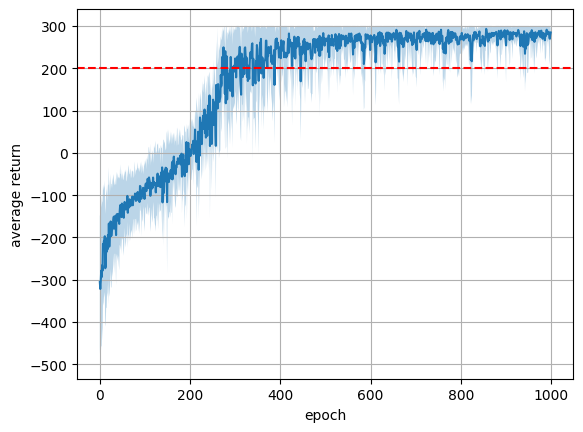

In [12]:
env_name="LunarLander-v3"
hidden_sizes=[64,64]
lr_actor=3e-4
epochs=1_000
batch_size=5_000
gamma=0.99
plot = True
n_critic_update = 80
lam = 0.95
lr_critic=1e-3


env = gym.make(env_name, continuous=True) if env_name == "LunarLander-v3" else gym.make(env_name)  # BipedalWalker is continuous per default

obs_dim = env.observation_space.shape[0]
n_acts = env.action_space.shape[0]

actor = mlp([obs_dim]+hidden_sizes+[2*n_acts])  # output-layer: 2*n_acts, for mean and logstd as the policy is stochastic
actor_optimizer = Adam(actor.parameters(), lr=lr_actor)


critic = mlp([obs_dim]+hidden_sizes+[1])
critic_optimizer = Adam(critic.parameters(), lr=lr_critic)
mse = nn.MSELoss()


returns = []
std = []

# training loop
progress_bar = tqdm(range(1, epochs+1))
for _ in progress_bar:
  batch_rets, batch_lens = train_one_epoch()
  avg_ret = np.mean(batch_rets)
  avg_len = np.mean(batch_lens)
  returns.append(avg_ret)
  std.append(np.std(batch_rets))
  progress_bar.set_postfix({"avg_ret": f"{avg_ret:5.0f}", "avg_len": f"{avg_len:5.0f}"})

if plot:
  plt.plot(returns)
  plt.fill_between(range(len(returns)), np.array(returns) - np.array(std), np.minimum(300, np.array(returns) + np.array(std)), alpha=0.3)
  plt.grid()
  goal = {"LunarLander-v3": 200, "BipedalWalker-v3": 300}.get(env_name, 0)
  plt.axhline(goal, color='r', linestyle='--')
  plt.xlabel('epoch')
  plt.ylabel('average return')
  timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
  plt.savefig(f"Reinforce_training_{timestamp}.png")
  plt.show()

#create video


In [34]:
import os
from gymnasium.wrappers import RecordVideo
video_dir = "/content/lunar_lander_video"
os.makedirs(video_dir, exist_ok=True)
env = gym.make("LunarLander-v3", render_mode="rgb_array", continuous=True)

env = RecordVideo(
    env,
    video_folder=video_dir,
    episode_trigger=lambda episode_id: True,  # record every episode
    name_prefix="policy"
)
obs, info = env.reset()
terminated = False
truncated = False

while not (terminated or truncated):
    logits = actor(torch.as_tensor(obs, dtype=torch.float32))
    act = logits[:n_acts].detach().squeeze(0).numpy()
    next_ob, rew, terminated, truncated, _ = env.step(act)

env.close()



In [35]:
import glob
from IPython.display import Video, display

video_files = glob.glob(video_dir + "/*.mp4")
video_files


['/content/lunar_lander_video/policy-episode-0.mp4']